# Pix2Pix로 Segmentation Map에서 실제 거리 이미지 생성하기

- Pix2Pix 모델을 사용해 Segmentation Map 이미지에서 실제 거리 이미지를 생성해보자.

## Pix2Pix 생성자
- 입력 : 이미지
- 출력 : 변환된 이미지
> 입력 이미지와 변환된 이미지 크기는 동일해야
- Encoder-Decoder 구조에 U-Net의 Skip Connection을 사용
### Encoder
- 입력 이미지의 사이즈를 줄여가면서 입력 이미지에서 중요한 representation 학습
- `bottleneck` : 인코더의 최종 출력 부분. 입력 이미지의 가장 중요한 특징만 담고 있음
> but, `bottleneck` 정보 만으로는 변환된 이미지 생성하기 부족!
### Decoder
- 입력 이미지와 동일 크기의 변환된 이미지 생성
### U-Net 구조
- 각 레이어별 Encoder와 Decoder가 Skip connection으로 연결되어 있음
- down-sampling 된 `bottleneck` 정보에 각 레이어별 Encoder에서 추가 정보를 받아 더 선명한 결과를 얻을 수 있다.

## Pix2Pix 판별자
- 기존의 DCGAN 판별자가 하나의 이미지에 대해 하나의 확률값을 출력
- 이와 달리 Pix2Pix 판별자는 하나의 이미지의 일부 영역 별로 여러 개의 확률값을 출력
- 하나의 이미지 안에서도 먼 거리에 있는 픽셀들은 서로 연관성이 없다! 
    - 👉 일정 사이즈의 패치마다 가짜인지 진짜인지 확률값을 도출한다
- 여러 출력값들의 평균으로 최종 판별자의 출력을 생성
![pix2pix 판별자](https://d3s0tskafalll9.cloudfront.net/media/images/patchgan.max-800x600.png)

# step1) 데이터 로드 및 전처리

## 1-1. train set 이미지 확인

학습용 데이터 셋에는 100장의 이미지가 있다.

In [2]:
import os

data_path = os.getenv('HOME')+'/aiffel/enode19/conditional_generation/citydata/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


- 임의로 6장의 데이터를 시각화해보자.
- 왼쪽에는 실제 도로 이미지가, 오른쪽에는 Segmentation Map 이미지가 있다.

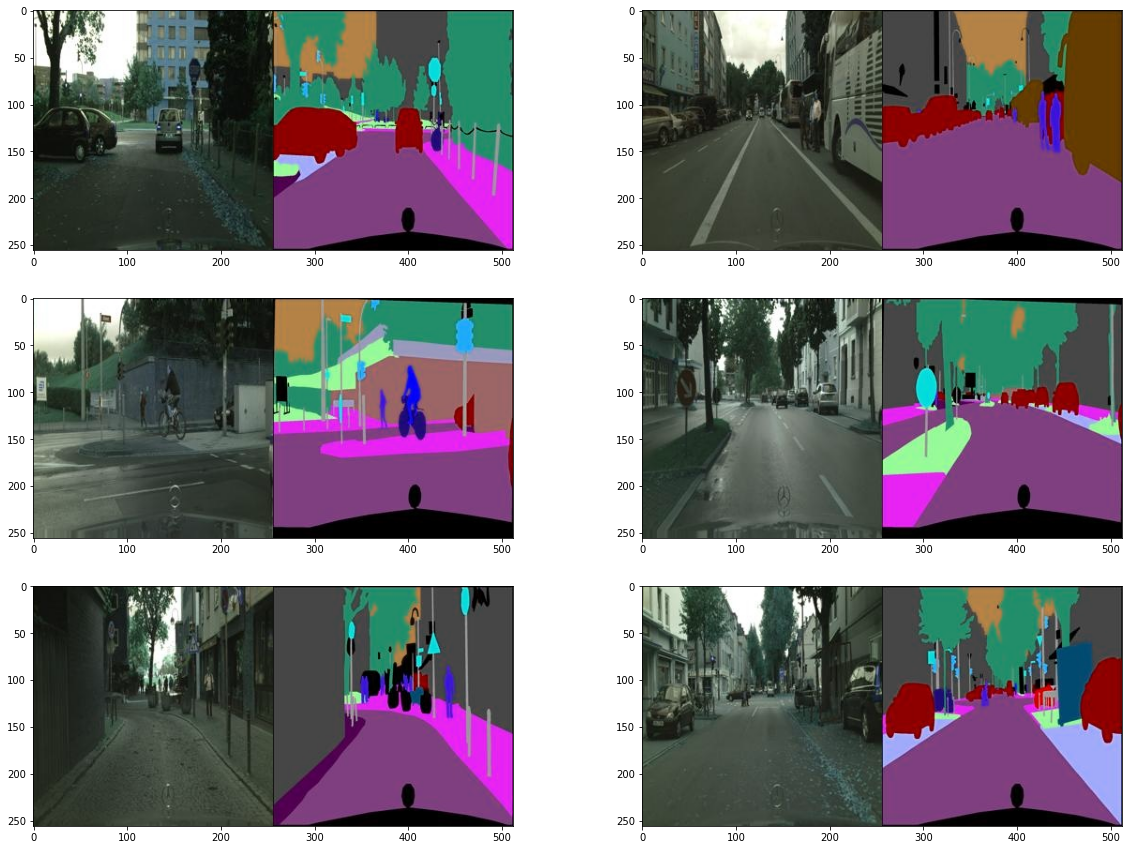

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 이미지 크기
- 한 장의 이미지가 (256, 512, 3) 사이즈 이다.
- 이를 (256, 256, 3) 사이즈의 이미지 2개로 분할해 사용한다.

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## 1-2. 이미지 Segmantation map, Road Image로 나누기

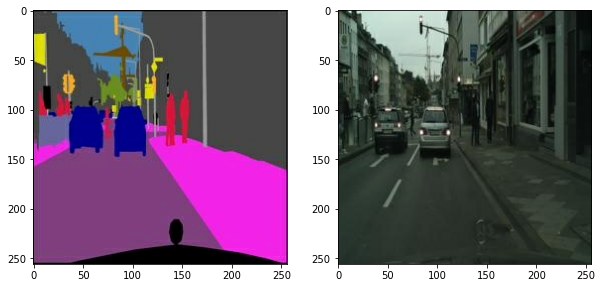

In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    road = img[:, :w, :] 
    road = tf.cast(road, tf.float32)
    segmap = img[:, w:, :] 
    segmap = tf.cast(segmap, tf.float32)
    return normalize(segmap), normalize(road)

f = data_path + os.listdir(data_path)[1]
segmap, road = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(segmap))
plt.subplot(1,2,2); plt.imshow(denormalize(road))

## 1-3. 데이터 증강

- def `apply_augmentation` : 도로 이미지와 해당 이미지의 Segmentation Map을 입력으로 받아 여러가지 데이터 증강 연산을 두 이미지에 동일하게 적용

- 두 이미지를 채널 축을 기준으로 연결 (256, 256, 3) + (256, 256, 3) -> (256, 256, 6)
- 50%의 확률로 reflect나 constant 패딩 적용
- `tf.image.random_crop()` : (256,256,6) 사이즈를 가지도록 랜덤으로 자르기
- `tf.image.random_flip_left_right()` : 50%의 확률로 좌우 반전
- `tf.image.random_flip_up_down()` : 50%의 확률로 상하 반전
- `tf.image.rot90()` : 50% 확률로 90도 회전

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(segmap, road):
    segmap = tf.concat([segmap, road], axis=-1) # 마지막 채널 축으로 연결
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(segmap, _pad, "REFLECT")
    else:
        padded = tf.pad(segmap, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

- 제대로 증강된 결과를 확인할 수 있다.

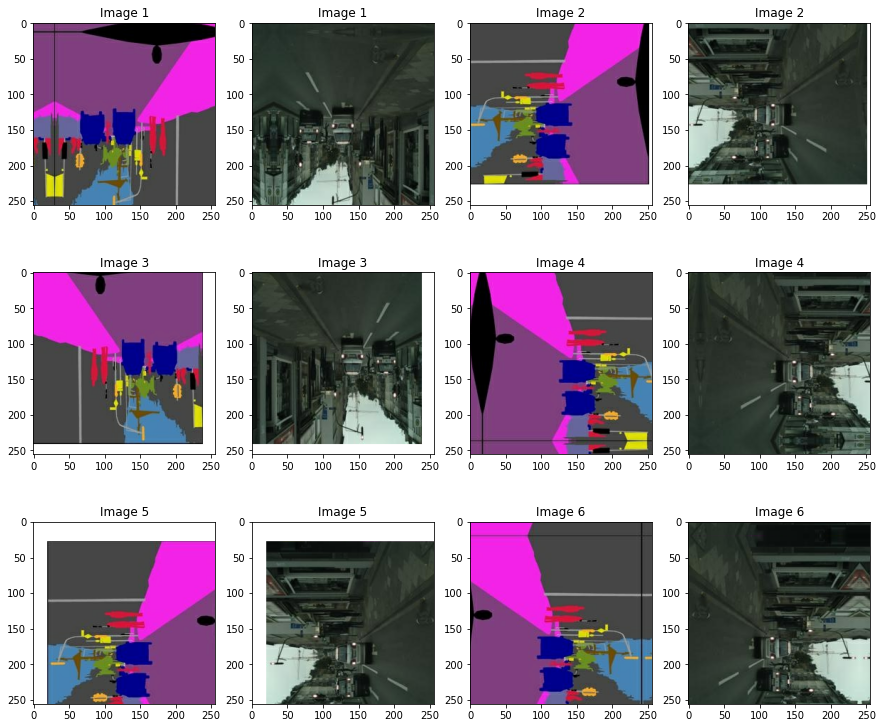

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segmap, augmented_road = apply_augmentation(segmap, road)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segmap)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_road)); plt.title(f"Image {img_n}")
    img_n += 1

## 1-4. train 데이터셋 생성
- def `get_train(path)`: 이미지를 불러오고 데이터 증강 함수를 적용해 train set을 구성한다.

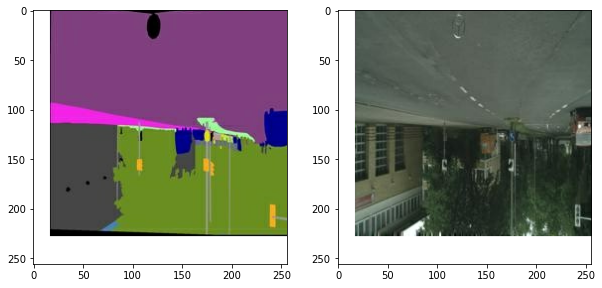

In [8]:
from tensorflow import data

def get_train(img_path):
    segmap, road = load_img(img_path)
    segmap, road = apply_augmentation(segmap, road)
    return segmap, road

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segmap, road = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(segmap[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(road[0].astype(np.uint8))

# step2) Pix2Pix 모델 정의

## 2-1. Pix2Pix 생성자 구성
![](https://d3s0tskafalll9.cloudfront.net/media/images/refer_g.max-800x600.png)

### Encoder 블록 정의
- 우선 Conv->BN->LeakyReLU를 하나의 블록으로 구성

In [9]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    # 사용할 필터 개수, BN 사용 여부 결정
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)


### 실제 Encoder 구성
- `filters[]` : 각 블록에서 사용할 필터 개수를 저장
- 블록 통과할 수록 이미지 (w,h) 크기 절반씩 감소
- 사용된 필터 개수는 64개 에서 512개로 증가

In [10]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0: # 첫번째 블록은 BN 사용 안함
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)): # 구성 레이어 확인
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

- Encoder 형태 확인

In [11]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

### Decoder 블록 정의
- Conv -> BN -> 50% 확률로 Dropout -> ReLU

In [12]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

### 실제 Decoder 구성
- 이미지 (w,h) 크기는 점점 증가
- 필터 개수는 점점 감소
- 최종 출력은 (256, 256, 3)

In [13]:
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3: # 처음 3개 블록만 Dropout 사용
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

- 모델 출력 형태 확인

In [14]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

# Generator에 U-Net 구조 적용
- 앞서 생성한 Encoder에서 마지막 레이어의 출력을 제외하고 저장
- Decoder에 각 계층 별 Encoder의 출력을 함께 입력으로 받음
- Decoder의 입력 채널 수가 늘어나서 Convolution 레이어에서 사용하는 필터 크기도 증가
- 단순 Encoder-Decoder에 비해 학습해야 할 파라미터 개수 증가.

In [15]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = [] # skip connection을 위해 각 Encoder 레이어에서의 출력 저장
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
        
        # Encoder의 마지막에서 두번째 출력과 Decoder의 첫 레이어 연결
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            # 마지막 축인 채널축을 기준으로 서로 연결
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [15]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_8 (EncodeBlock)    (None, 128, 128, 64) 3072        input_3[0][0]                    
__________________________________________________________________________________________________
encode_block_9 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block_8[0][0]             
__________________________________________________________________________________________________
encode_block_10 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_9[0][0]             
____________________________________________________________________________________________

## 2-2. Pix2Pix 판별자 구성

## 판별자 구성 요소
- 판별을 위해 sigmoid 사용
![](https://d3s0tskafalll9.cloudfront.net/media/images/refer_d.max-800x600.png)
- 입력 : 진짜 이미지, 생성된 이미지
- 두개 입력 연결 -> Encoder 블록 5개 -> 1차원 출력 블록

- 마지막 2개 블록의 출력은 입력에 비해 (width, height) 크기가 1씩 감소
1. 패딩 레이어 통과 layers.ZeroPadding2D() → (130,130,32)
    - w,h 양쪽에 1씩 패딩 -> 총 2만큼 크기 증가
2. Convolution 레이어 통과 layers.Conv2D(64,4,1,"valid") → (127,127,64)
    - 패딩 없이 필터 크기 4, stride 1인 Conv 거쳐서 (w, h) 3씩 감소
    - $$출력크기 = \frac{(입력크기+2*패딩사이즈-필터크기)}{스트라이드+1}$$
    - 채널수 = 사용한 필터 개수
3. BatchNormalization 레이어 통과 layers.BatchNormalization() → (127,127,64)
4. LeakyReLU 활성화 레이어 통과 layers.LeakyReLU(0.2) → (127,127,64)
    - BN, LeakyReLU는 출력에 영향 x

In [16]:
class DiscBlock(layers.Layer):
    # 필터 개수, stride 간격, 출력 피쳐맵 크기 조절, BN 사용 여부, 활성화 함수 사용 여부 결정
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [17]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_30 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [18]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [19]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

- (256,256,3) 입력 넣을 때 (30,30) 출력 되는지 확인

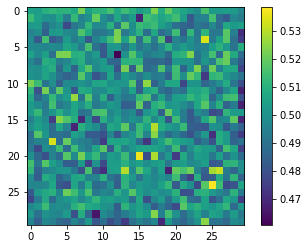

In [20]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# step3) 모델 학습

## 3-1. 손실함수 정의
- L1이랑 cGAN loss 사용 시 가장 좋은 결과

In [21]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    # 가짜이미지 - 실제 이미지 간 MAE 계산(L1 loss)
    l1_loss = mae(real_output, fake_output)
    # 가짜 이미지랑 실제 이미지 비교
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    # 실제 이미지는 1로 채워진 벡터와 비교
    # 가짜 이미지는 0으로 채워진 벡터와 비교
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

## 3-2. Optimizer 정의
- Adam 사용

In [22]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

## 3-3. step별 가중치 업데이트
배치 하나 크기 만큼 데이터 입력 시 가중치 1회 업데이트

In [23]:
@tf.function
def train_step(segmap, real_road):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_road = generator(segmap, training=True)
        # Discriminator 예측
        fake_disc = discriminator(segmap, fake_road, training=True)
        real_disc = discriminator(segmap, real_road, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_road, real_road, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

## 3-4. 학습 수행
- 실제 학습 진행

In [24]:
EPOCHS = 200 #약 30분 정도 소요 됩니다.

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[],'l1_loss':[],'disc_loss':[]}
for epoch in range(1, EPOCHS+1):
    for i, (segmap, road) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segmap, road)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % EPOCHS == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[200]                     
Generator_loss:1.5552                     
L1_loss:0.1790                     
Discriminator_loss:0.6084

EPOCH[2] - STEP[200]                     
Generator_loss:1.3487                     
L1_loss:0.1721                     
Discriminator_loss:0.5119

EPOCH[3] - STEP[200]                     
Generator_loss:1.1926                     
L1_loss:0.1744                     
Discriminator_loss:0.9670

EPOCH[4] - STEP[200]                     
Generator_loss:1.4381                     
L1_loss:0.2029                     
Discriminator_loss:0.3873

EPOCH[5] - STEP[200]                     
Generator_loss:1.3920                     
L1_loss:0.1802                     
Discriminator_loss:0.5918

EPOCH[6] - STEP[200]                     
Generator_loss:0.6066                     
L1_loss:0.1807                     
Discriminator_loss:1.8506

EPOCH[7] - STEP[200]                     
Generator_loss:1.2408                     
L1_loss:0.1883             

EPOCH[57] - STEP[200]                     
Generator_loss:0.4935                     
L1_loss:0.1963                     
Discriminator_loss:1.4454

EPOCH[58] - STEP[200]                     
Generator_loss:1.8601                     
L1_loss:0.1674                     
Discriminator_loss:2.4361

EPOCH[59] - STEP[200]                     
Generator_loss:1.2145                     
L1_loss:0.1777                     
Discriminator_loss:0.4745

EPOCH[60] - STEP[200]                     
Generator_loss:0.7853                     
L1_loss:0.1571                     
Discriminator_loss:1.5692

EPOCH[61] - STEP[200]                     
Generator_loss:1.5656                     
L1_loss:0.1733                     
Discriminator_loss:0.9317

EPOCH[62] - STEP[200]                     
Generator_loss:2.0185                     
L1_loss:0.1749                     
Discriminator_loss:0.3604

EPOCH[63] - STEP[200]                     
Generator_loss:1.8780                     
L1_loss:0.1832      

EPOCH[112] - STEP[200]                     
Generator_loss:1.8128                     
L1_loss:0.1786                     
Discriminator_loss:0.3025

EPOCH[113] - STEP[200]                     
Generator_loss:0.8415                     
L1_loss:0.1656                     
Discriminator_loss:1.1676

EPOCH[114] - STEP[200]                     
Generator_loss:0.5637                     
L1_loss:0.1663                     
Discriminator_loss:1.4461

EPOCH[115] - STEP[200]                     
Generator_loss:2.3455                     
L1_loss:0.1739                     
Discriminator_loss:0.9459

EPOCH[116] - STEP[200]                     
Generator_loss:1.4215                     
L1_loss:0.2272                     
Discriminator_loss:0.3367

EPOCH[117] - STEP[200]                     
Generator_loss:1.7739                     
L1_loss:0.1982                     
Discriminator_loss:0.2478

EPOCH[118] - STEP[200]                     
Generator_loss:2.0719                     
L1_loss:0.152

EPOCH[167] - STEP[200]                     
Generator_loss:1.9583                     
L1_loss:0.1739                     
Discriminator_loss:0.5447

EPOCH[168] - STEP[200]                     
Generator_loss:0.5227                     
L1_loss:0.1813                     
Discriminator_loss:1.0844

EPOCH[169] - STEP[200]                     
Generator_loss:0.6419                     
L1_loss:0.1751                     
Discriminator_loss:0.8967

EPOCH[170] - STEP[200]                     
Generator_loss:1.1914                     
L1_loss:0.1563                     
Discriminator_loss:1.0368

EPOCH[171] - STEP[200]                     
Generator_loss:1.2690                     
L1_loss:0.1782                     
Discriminator_loss:0.8804

EPOCH[172] - STEP[200]                     
Generator_loss:1.3935                     
L1_loss:0.1643                     
Discriminator_loss:0.5011

EPOCH[173] - STEP[200]                     
Generator_loss:1.7646                     
L1_loss:0.156

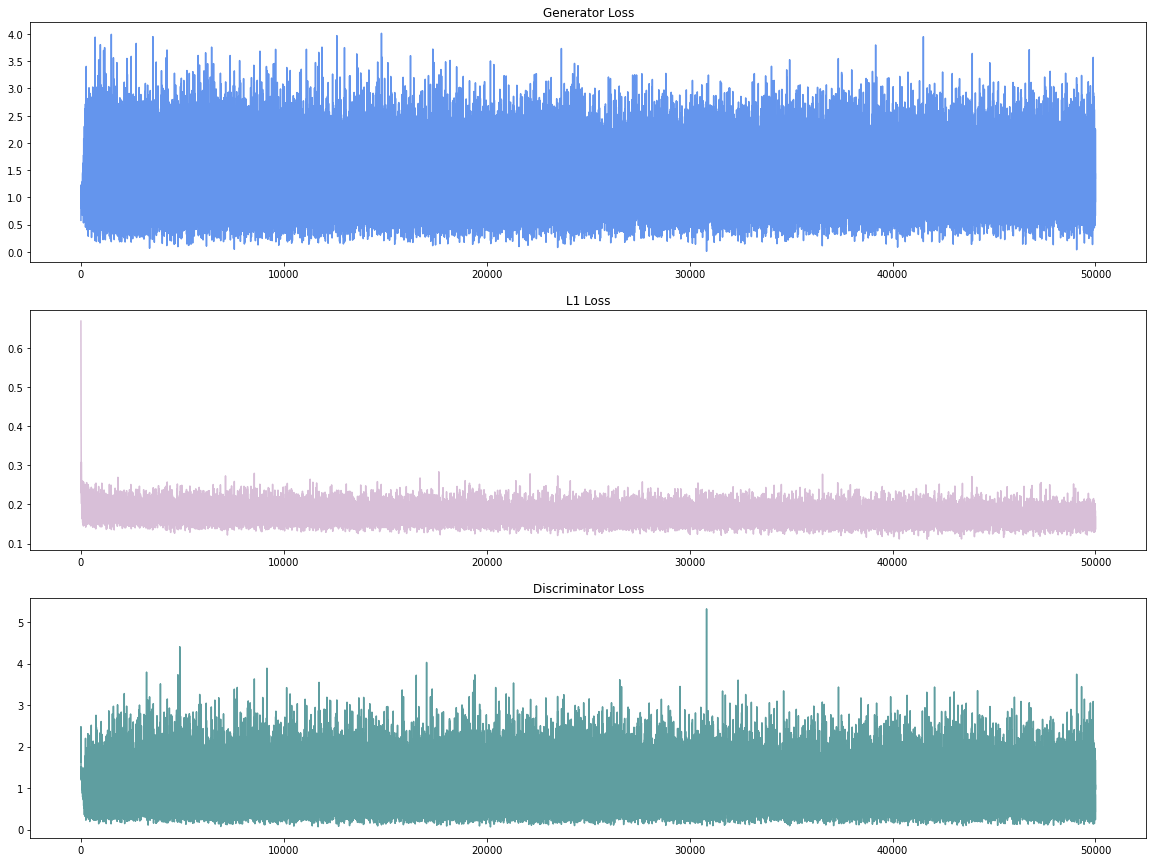

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.subplot(311)
plt.plot(history['gen_loss'], color='cornflowerblue')
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'], color='thistle')
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'], color='cadetblue')
plt.title('Discriminator Loss')

plt.show()

# step4) 모델 인퍼런스

In [26]:
test_data_path = os.getenv('HOME')+'/aiffel/enode19/conditional_generation/citydata/cityscapes/val/'

In [27]:
test_list = os.listdir(test_data_path)
test_list

['5.jpg', '2.jpg', '1.jpg', '4.jpg', '3.jpg']

In [28]:
def make_road(test_ind):
    f = test_data_path + os.listdir(test_data_path)[test_ind]
    test_segmap, test_road = load_img(f)

    pred = generator(tf.expand_dims(test_segmap, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(test_segmap))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(test_road))
    plt.show()

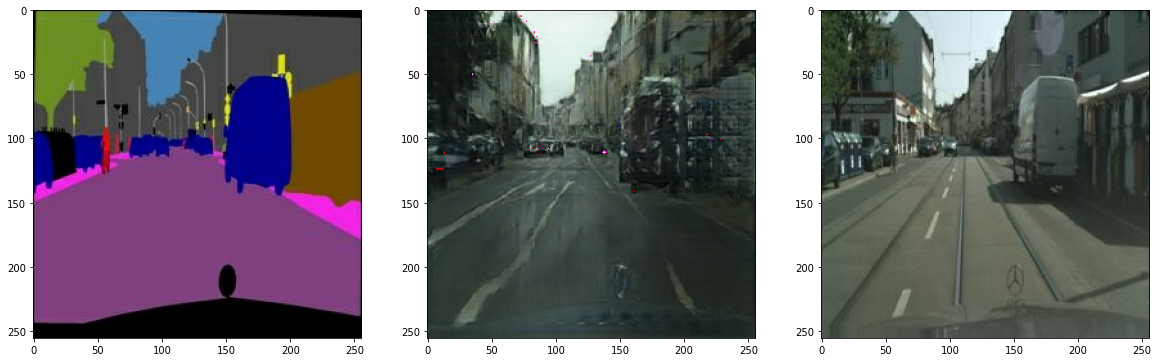

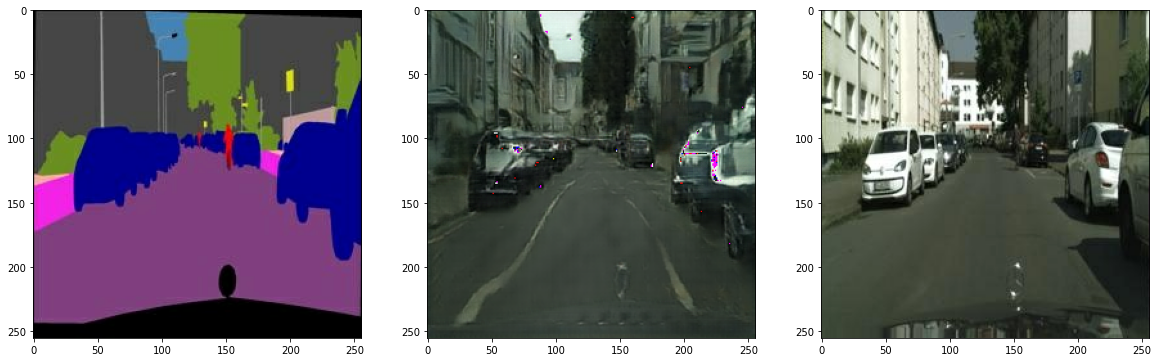

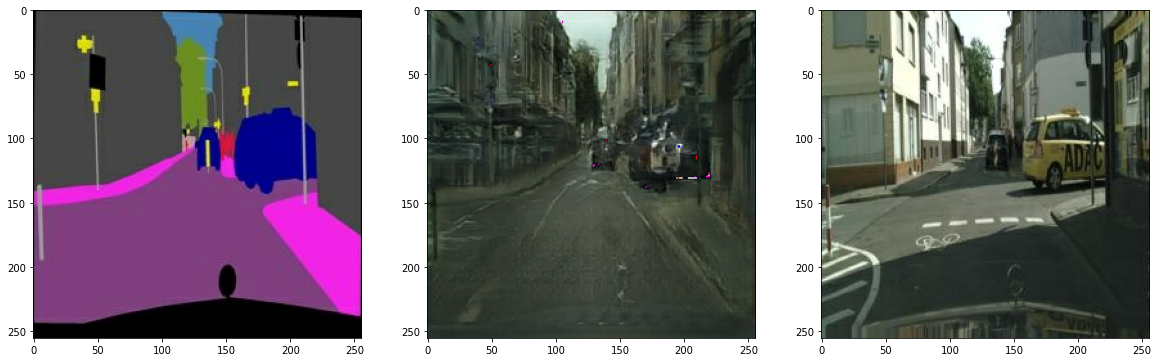

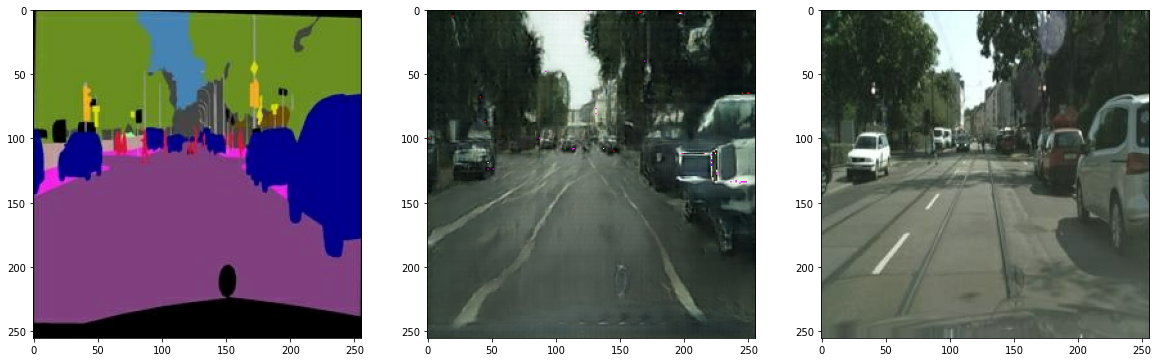

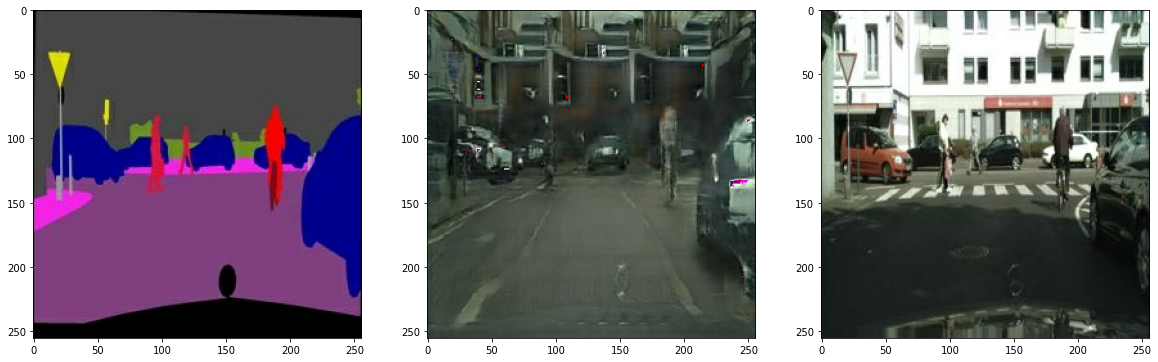

In [29]:
for i in range(5):
    make_road(i)

- 제법 차 영역에 차 같은 무언가를 생성해내는 모습을 볼 수 있다.
- 이미지 중간 중간에 마젠타 색의 픽셀이 부분 부분 보이는데 왜 생성된건지 궁금하다.
- Segmentation에는 도로 선에 대한 영역 구분이 없는데도 어느 정도 도로 선을 생성하는 모습을 볼 수 있었다.

# 회고
- 이전 노드에서 언급하고 지나갔던 Pix2Pix를 직접 구현해볼 수 있었다.
- 딱히 생성자, 판별자 loss가 수렴하는 모습은 볼 수 없었지만 확실히 에폭 수를 늘리니 더욱 그럴싸한 이미지를 생성해냈다.
- 유의미한 결과를 보려면 얼마나 더 학습량을 늘려야할까. 역시 GAN은 어렵다.